## Compare SOM output with zotbin

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
!pwd

/global/cscratch1/sd/belaa/lsst/repos/pz_bayes/notebooks


In [3]:
import sys
sys.path = ['/global/cscratch1/sd/belaa/lsst/repos/tomo_challenge'] + sys.path

In [4]:
import pathlib
from somviz import som
import jax_cosmo
import tomo_challenge as tc
import seaborn as sns
import pandas as pd
import zotbin.binned as binned
import zotbin.group as group

sns.set()

Found classifier IBandOnly
Found classifier RandomForest
Found classifier Random


In [5]:
data_path = pathlib.Path('/global/cscratch1/sd/belaa/lsst/repos/tomo_challenge')
dc2_path = data_path / 'data/training.hdf5'
buzzard_path = data_path / 'data_buzzard/training.hdf5'

#### Load the data

In [6]:
bands = 'riz'
include_errors = False
include_colors = False

dc2_train = tc.load_data(dc2_path, bands, errors=include_errors, colors=include_colors, array=True)
buzzard_train = tc.load_data(buzzard_path, bands, errors=include_errors, colors=include_colors, array=True)

dc2_train_z = tc.load_redshift(dc2_path)
buzzard_train_z = tc.load_redshift(buzzard_path)

/global/cscratch1/sd/belaa/lsst/repos/tomo_challenge/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


#### See what it looks like

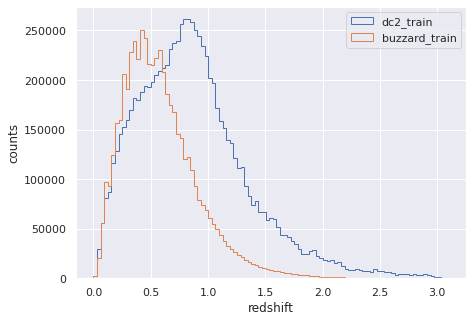

In [6]:
plt.figure(figsize=(7,5))
plt.hist(dc2_train_z, bins=np.linspace(0,3.1,100), histtype='step', label='dc2_train')
plt.hist(buzzard_train_z, bins=np.linspace(0,3.1,100), histtype='step', label='buzzard_train')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('counts');

In [8]:
def make_df(data, z, bands=bands):
    df = pd.DataFrame(data, columns=list(bands))
    df['redshift'] = z
    return(df)

def bin_percentiles(data, z, nzbins=10, bands=bands):
    df = make_df(data, z, bands)
    zbins = np.percentile(df['redshift'], np.linspace(0, 100, nzbins + 1))
    zbins[-1] += 1
    iz = np.digitize(df['redshift'], zbins) - 1
    assert np.all((iz >= 0) & (iz < nzbins))
    df['iz'] = iz
    return(df)

def make_pairplot(data, z, nzbins=10, bands=bands, thin=2000):
    df = bin_percentiles(data, z, nzbins=10, bands=bands)
    sns.pairplot(df[::thin], vars=list(bands) + ['redshift'],
             hue='iz', plot_kws=dict(edgecolor='none', alpha=0.25, s=5), diag_kind='kde');

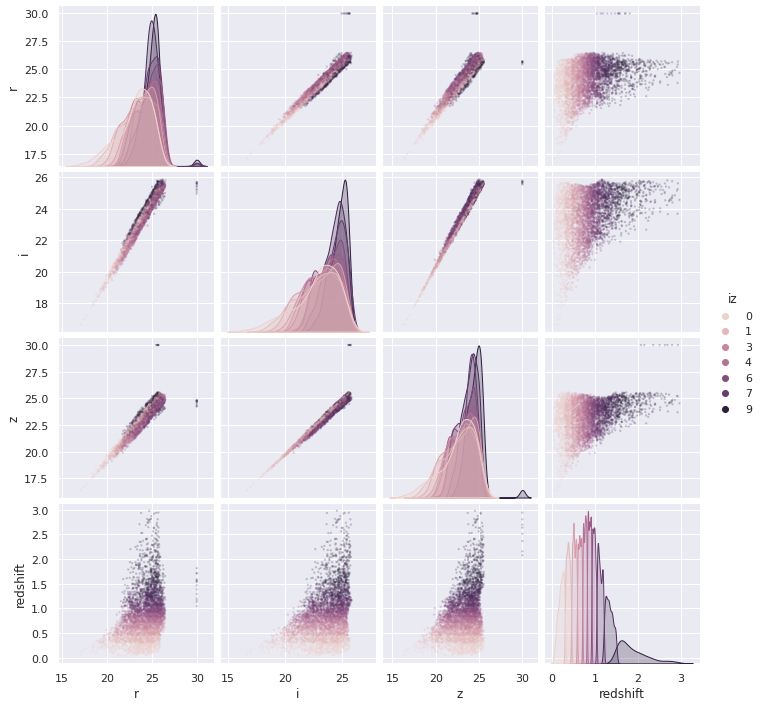

In [8]:
make_pairplot(dc2_train, dc2_train_z)

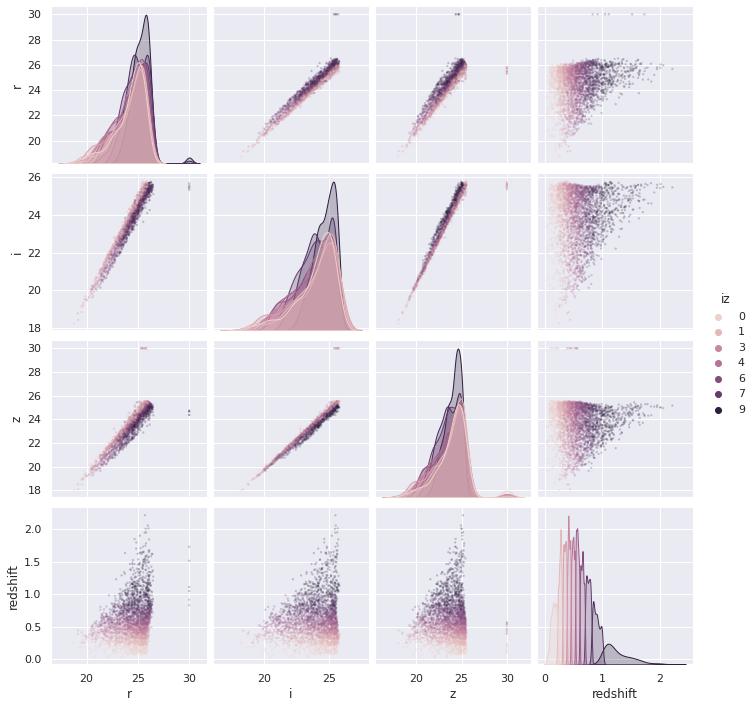

In [9]:
make_pairplot(buzzard_train, buzzard_train_z)

#### Make SOM

In [44]:
nside = -12
niter = 10
thin = 10

X = dc2_train[::thin]
Y = dc2_train_z[::thin]

In [56]:
len(X)

861562

In [46]:
start = time.time()
som_train = som.SelfOrganizingMap(som.Grid(nside, nside))
som_train.fit(X, Y, maxiter=niter)
print(time.time() - start)

448.1172924041748


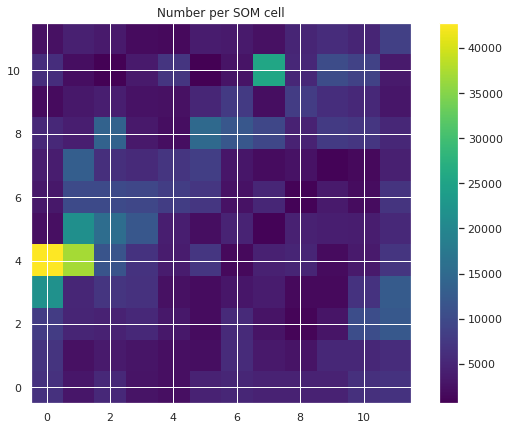

In [47]:
som_train.plot_counts_per_cell()

In [15]:
# from: https://github.com/dkirkby/zotbin/blob/master/zotbin/group.py

def plotzgrp(zhist, zedges=None, stretch=4, sort=False, figsize=(10,5)):
    ngrp, nzbin = zhist.shape
    if zedges is None:
        zc = np.arange(nzbin)
    else:
        zc = 0.5 * (zedges[1:] + zedges[:-1])
    zplot = zhist / zhist.max(axis=1, keepdims=True)
    if sort:
        zavg = np.sum(zhist * np.arange(nzbin), axis=1) / np.sum(zhist, axis=1)
        zplot = zplot[np.argsort(zavg)]
    fig = plt.figure(figsize=figsize)
    yoffsets = np.arange(ngrp) / stretch
    for dndz, dy in zip(zplot[::-1], yoffsets[::-1]):
        #plt.plot(zc, dndz + dy, 'r-', alpha=0.5)
        plt.fill_between(zc, dndz + dy, dy, facecolor=(1, 1, 1, 0.75), edgecolor=(1, 0, 0, 0.5), lw=1)
    plt.gca().axis('off')
    plt.tight_layout()

def get_zedges(zmax, nzbin, zplot=None):
    """Calculate redshift bin edges equally spaced in comoving distance.
    """
    # Tabulate comoving distance over a grid spanning the full range of input redshifts.
    zgrid = np.linspace(0, zmax, 1000)
    agrid = 1 / (1 + zgrid)
    model = jax_cosmo.parameters.Planck15()
    chi_grid = jax_cosmo.background.radial_comoving_distance(model, agrid)
    # Compute bin edges that are equally spaced in chi.
    chi_edges = np.linspace(0, chi_grid[-1], nzbin + 1)
    zedges = np.empty(nzbin + 1)
    zedges[0] = 0.
    zedges[-1] = zmax
    zedges[1:-1] = np.interp(chi_edges[1:-1], chi_grid, zgrid)
    aedges = 1 / (1 + zedges)
    if zplot is not None:
        plots = {
            'Redshift $z$': zplot,
            'Scale factor $a$': 1 / (1 + zplot),
            'Comoving distance $\chi$ [Mpc]': np.interp(zplot, zgrid, chi_grid)
        }
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        for ax, label in zip(axes, plots):
            ax.hist(plots[label], bins=2 * nzbin, histtype='stepfilled', color='r', alpha=0.5)
            ax.set_xlabel(label)
        for ax, edges in zip(axes, (zedges, aedges, chi_edges)):
            ax.set_yticks([])
            ax.set_xlim(edges[0], edges[-1])
            for edge in edges[1:-1]:
                ax.axvline(edge, c='k', lw=1, alpha=0.5)
        plt.tight_layout()
    return zedges

In [48]:
ngrp = nside ** 2
nzbin = 80

zedges = binned.get_zedges(Y.max(), nzbin)

In [49]:
zhist = np.empty((ngrp,nzbin))

for i in range(ngrp):
    zhist[i], _ = np.histogram(som_train._target_dist[i], bins=nzbin)

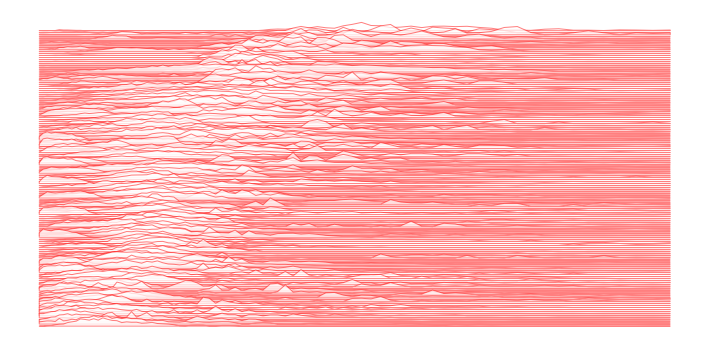

In [50]:
group.plotzgrp(zhist, zedges, sort=True)

### Group bins with zotbin

In [60]:
thin = 10
X = dc2_train[::thin]
Y = dc2_train_z[::thin]

nzbin = 80
zedges = binned.get_zedges(Y.max(), nzbin)

In [61]:
len(X)

861562

#### Run on X, Y

In [52]:
group.groupbins(X, Y, zedges, npct=10, method='weighted', sigma=0.2,
              ngrp_save=(400, 300, 200, 150, 100, 75), maxfrac=0.02, minfrac=0.005,
              validate=False, validate_interval=1000, maxiter=None,
              plot_interval=None, savename='group_{N}.npz')

Grouping with ndata=861562, nmin=4308, nmax=17231, nzbin=80, nfbin=1000.
Finalizing result with 150 groups...
Saved 150 groups to group_150.npz
Reduced to 104 groups after 100 iterations.
Finalizing result with 100 groups...
Saved 100 groups to group_100.npz
Finalizing result with 75 groups...
Saved 75 groups to group_75.npz
Reached min_groups=75 after 151 iterations.


In [53]:
grps = np.load('group_150.npz')
grps.files;

In [54]:
zhist = grps['zhist']

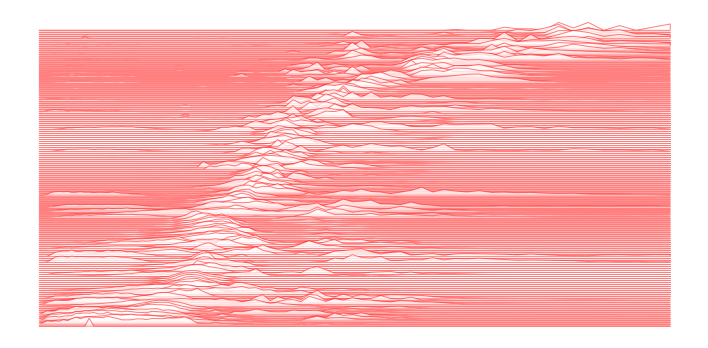

In [55]:
group.plotzgrp(zhist, zedges, sort=True)

#### Run on dc2_train

In [62]:
len(dc2_train)

8615613

In [59]:
group.groupbins(dc2_train, dc2_train_z, zedges, npct=10, method='weighted', sigma=0.2,
              ngrp_save=(400, 300, 200, 150, 100, 75), maxfrac=0.02, minfrac=0.005,
              validate=False, validate_interval=1000, maxiter=None,
              plot_interval=None, savename='group_{N}.npz')

Grouping with ndata=8615613, nmin=43078, nmax=172312, nzbin=80, nfbin=1000.
Finalizing result with 200 groups...
Saved 200 groups to group_200.npz
Finalizing result with 150 groups...
Saved 150 groups to group_150.npz
Reduced to 118 groups after 100 iterations.
Finalizing result with 100 groups...
Saved 100 groups to group_100.npz
Finalizing result with 75 groups...
Saved 75 groups to group_75.npz
Reached min_groups=75 after 192 iterations.
